In [36]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from tensorflow.keras.preprocessing.text import Tokenizer
import json

import pandas as pd

# Set seed for random generators
algorithm_globals.random_seed = 42

In [34]:
def prepare_x_y(df, unique_actions, number_of_actions):
    # recover all the actions in order
    #print(df)
    actions = df['activity'].values
    
    timestamps = df.index.values

    #timestamps = pd.to_datetime(timestamps, format='%Y%m%d')
    dates = timestamps.astype('M8[D]')
    df['dates'] = dates
    df.set_index('dates')

    print(('total actions', len(actions)))
    # use tokenizer to generate indices for every action
    tokenizer = Tokenizer(lower=False)
    tokenizer.fit_on_texts(actions.tolist())
    action_index = tokenizer.word_index  

    
    # translate actions to indexes
    actions_by_index = []
    for action in actions:
        actions_by_index.append(action_index[action])

    df['actions_by_index'] = actions_by_index

    dates_dict = {}
    for index, row in df.iterrows():
        #Remove the 'None' that are tokenized as 'None'
        if str(row['actions_by_index']) != '2':
            activity_list = dates_dict.get(str(index).split(" ")[0], [])
            activity_list.append(row['actions_by_index'])
            dates_dict[str(index).split(" ")[0]] = activity_list
    
    to_remove = []
    for key in dates_dict:
        if len(dates_dict[key]) <= number_of_actions:
            to_remove.append(key)

    for remove in to_remove:
        dates_dict.pop(remove)

    X_actions = []
    y = []

    for key in dates_dict:
        last_action = len(dates_dict[key]) - 1

        for i in range(last_action-number_of_actions):
            X_actions.append(actions_by_index[i:i+number_of_actions])
            # represent the target action as a one-hot for the softmax
            target_action = ''.join(i for i in actions[i+number_of_actions] if not i.isdigit()) # remove the period if it exists
            #target_action_onehot = np.zeros(len(unique_actions))
            #target_action_onehot[unique_actions.index(target_action)] = 1.0
            y.append(target_action)
    
    return X_actions, y

In [21]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("qasm_simulator"))

In [54]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 5
num_samples = 20

print('Loading DATASET...')
DATASET = "D:\\Github\\DL_HAR\\kasteren_house_a\\reduced\\base_kasteren_reduced.csv"
print(DATASET)
df_har = pd.read_csv(DATASET, parse_dates=[[0]], index_col=0, sep=' ', header=None)
df_har.columns = ['date','sensor', 'action', 'event', 'activity']
df_har.index.names = ["timestamp"]
print('DATASET loaded')

UNIQUE_ACTIONS = 'D:\\Github\\DL_HAR\\kasteren_house_a\\reduced\\unique_activities.json'
unique_actions = json.load(open(UNIQUE_ACTIONS, 'r'))
total_actions = len(unique_actions)
print(total_actions)

X_actions, y = prepare_x_y(df_har, unique_actions, num_inputs) 

total_examples = len(X_actions)
test_per = 0.2
limit = int(test_per * total_examples)
X_actions_train = X_actions[limit:]
X_actions_test = X_actions[:limit]
y_train = y[limit:]
y_test = y[:limit]
print(('Different actions:', total_actions))
print(('Total examples:', total_examples))
print(('Train examples:', len(X_actions_train), len(y_train))) 
print(('Test examples:', len(X_actions_test), len(y_test)))
X_actions_train = np.array(X_actions_train)
#y_train = np.array(y_train)
X_actions_test = np.array(X_actions_test)
#y_test = np.array(y_test)
print('Shape (X,y):')
#print((X_actions_train.shape))
#print((y_train.shape))


Loading DATASET...
D:\Github\DL_HAR\kasteren_house_a\reduced\base_kasteren_reduced.csv
DATASET loaded
8
('total actions', 1179)
('Different actions:', 8)
('Total examples:', 823)
('Train examples:', 659, 659)
('Test examples:', 164, 164)
Shape (X,y):


In [50]:
# Set up QNN
# Note: we are not providing them explicitly in this examples,
# but TwoLayerQNN requires a feature_map and ansatz to work.
# By default, these parameters are set to  ZZFeatureMap
# and RealAmplitudes (respectively).
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)
print(qnn1.operator)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * ZZZZZ),
  CircuitStateFn(
       ┌─────────────────────────────────────────┐»
  q_0: ┤0                                        ├»
       │                                         │»
  q_1: ┤1                                        ├»
       │                                         │»
  q_2: ┤2 ZZFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├»
       │                                         │»
  q_3: ┤3                                        ├»
       │                                         │»
  q_4: ┤4                                        ├»
       └─────────────────────────────────────────┘»
  «     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                                                                                               ├
  «     │                                                                          

In [55]:
# Convert to torch Tensors
X_ = Tensor(X_actions_train)
#y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y_train)

ValueError: too many dimensions 'str'

In [25]:
# Test with a single input
model1(X_[0, :])

tensor([0.1543], grad_fn=<_TorchNNFunctionBackward>)

In [26]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

22.263240814208984
20.643505096435547
20.176959991455078
19.1602783203125
16.4984130859375
17.592178344726562
14.79940414428711
14.80987548828125
14.708248138427734
13.35516357421875
12.651985168457031
12.799190521240234
12.320198059082031
12.568256378173828
12.377925872802734
11.825992584228516
11.972843170166016
12.363330841064453
12.020210266113281
12.139232635498047


tensor(22.2632, grad_fn=<MseLossBackward0>)

Accuracy: 0.95


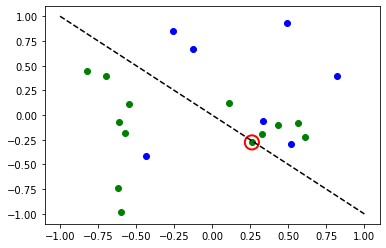

In [27]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [28]:
# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))


# Define CircuitQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=qi,
)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [-0.06588141  0.08502402  0.01621223 -0.03062604  0.0181831  -0.09543923
  0.09171184 -0.00353931  0.05654705 -0.083454  ]


In [29]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure)

0.7175211906433105
0.7150558233261108
0.6993451714515686
0.6540291905403137
0.6389881372451782
0.6454650163650513
0.6375232934951782
0.6263939738273621
0.6278427839279175
0.6673161387443542
0.6201383471488953
0.6229459047317505
0.6236528754234314
0.6206197738647461
0.6208776235580444
0.6223248839378357
0.6145735383033752
0.6184806823730469
0.6181193590164185
0.6191360950469971


tensor(0.7175, grad_fn=<NllLossBackward0>)

Accuracy: 0.5


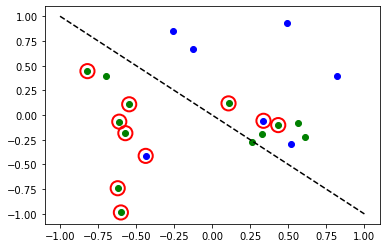

In [31]:
# Evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()